In [1]:
from PIL import Image
from skimage.morphology import medial_axis, skeletonize
import numpy as np

In [2]:
mask = np.array(Image.open('download.png'))
img = np.array(Image.open('crop.png'))

mask = mask / mask.max()
img = img / img.max()

In [3]:
def show(img):
    display(Image.fromarray((img * 255).astype(np.uint8)))

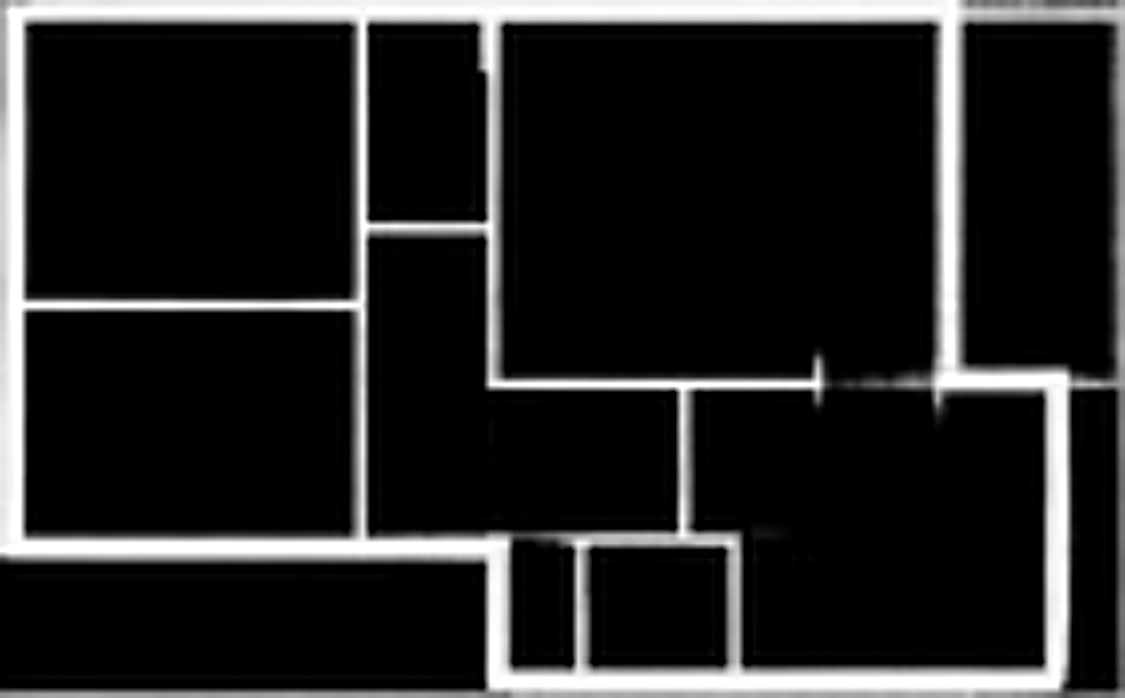

In [4]:
show(mask)

In [5]:
import cv2
import skimage.filters as spatial_filter
from skimage.morphology import disk
import math
from skimage.feature import corner_peaks, corner_subpix, corner_harris, corner_fast, corner_foerstner, corner_kitchen_rosenfeld, corner_moravec, corner_shi_tomasi

mask[[0, -1],:] = 0
mask[:,[0, -1]] = 0

conv = spatial_filter.butterworth(mask, cutoff_frequency_ratio=0.16, order=8.0, high_pass=False) >= 0.3
skel = skeletonize(conv)

# pad_size = 0
# scaled_skel = np.pad(skel, (pad_size, pad_size), mode='constant', constant_values=0)

# coords = corner_peaks(corner_kitchen_rosenfeld(scaled_skel), min_distance=1, threshold_rel=0.02)
# coords = corner_subpix(scaled_skel, coords, window_size=48)

# L = 5

# filt = np.zeros_like(skel, dtype=np.int32)
# filt = (filt - skel) - 1
# for idx,coord in enumerate(coords):
#     filt[round(coord[0] - L): round(coord[0] + L), round(coord[1] - L): round(coord[1] + L)] = idx

# show(np.where(((filt + 1) / (filt + 1).max()) == 0, 0, ((filt + 1) / (filt + 1).max()) + 100))

In [6]:
map_filt = np.zeros_like(skel) - 1
skel_arguments = np.argwhere(skel)
skel_cnt = len(skel_arguments)
for idx,[x,y] in enumerate(skel_arguments):
    map_filt[x,y] = idx
is_valid_pts = lambda pts: (pts >= np.zeros(2)).all() and (pts < np.array(skel.shape)).all()
conn8 = np.array([
    [0, 0, 1, 1, 1, -1, -1, -1],
    [1, -1, 0, 1, -1, 0, 1, -1]
]).T
skel_edge = []
skel_degree = np.zeros((skel_cnt), dtype=np.int8)
for _ in range(skel_cnt):
    skel_edge.append([])
for idx,pts in enumerate(skel_arguments):
    for conn in conn8:
        next_pts = pts + conn
        if not is_valid_pts(next_pts):
            continue
        next_target = map_filt[next_pts[0], next_pts[1]]
        if next_target > -1:
            skel_edge[idx].append(next_target)
            skel_degree[idx] += 1

In [7]:
# graph partitioning
static_pts = np.where(skel_degree > 2)[0]
if static_pts.shape[0] == 0:
    static_pts = np.random.choice(np.where(skel_degree > 1)[0], 1)

visited = np.zeros((skel_cnt), dtype=np.bool_)
partitions = []

for point in static_pts:
    if visited[point]:
        continue
    queue = []
    queue.append(point)
    while len(queue) > 0:
        current = queue.pop(0)
        visited[current] = True

        for connection in skel_edge[current]:
            if visited[connection]:
                continue

            # create new partition
            part = [current]
            curr = current
            next = connection
            
            while True:
                parent = curr
                curr = next
                part.append(curr)
                if skel_degree[curr] != 2 or curr == current:
                    break
                visited[curr] = True
                for conn in skel_edge[curr]:
                    if visited[conn]:
                        continue
                    next = conn


            partitions.append(part)
            if skel_degree[curr] > 2:
                queue.append(curr)

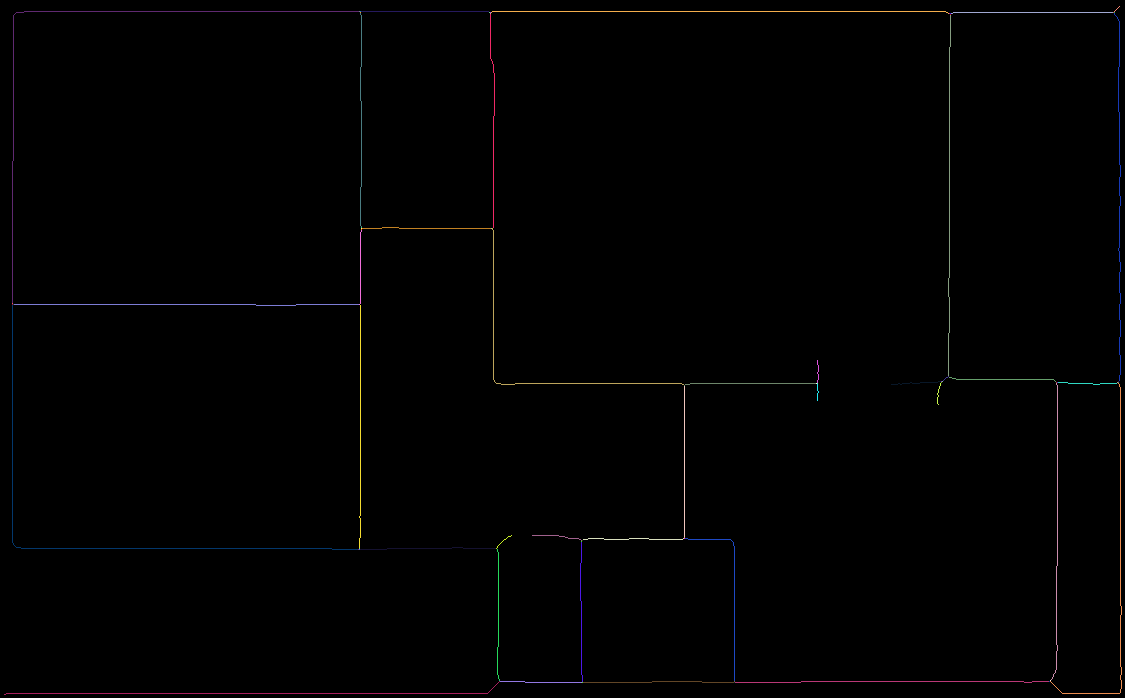

In [8]:
a = np.zeros((*skel.shape, 3))
for partition in partitions:
    index = skel_arguments[partition]
    a[index[:,0], index[:,1]] = np.random.rand(1, 3)
show(a)

In [9]:
from rdp import rdp
from skimage.feature import corner_subpix
import cv2

new_connections = []
used_coords = []
for partition in partitions:
    partition = np.array(partition)
    partition_mask = rdp(skel_arguments[partition], epsilon=1.0, return_mask=True)
    new_partition = partition[partition_mask]
    used_coords_partition = []
    for coord in new_partition:
        used_coords_partition.append(coord)
    for idx in range(1, len(new_partition)):
        new_connections.append([new_partition[idx - 1], new_partition[idx]])
    used_coords += used_coords_partition

inverse_used_coords = np.zeros((skel_cnt), dtype=np.int32) - 1
for i,coord in enumerate(used_coords):
    inverse_used_coords[coord] = i
for i,[u,v] in enumerate(new_connections):
    new_connections[i] = [
        inverse_used_coords[u],
        inverse_used_coords[v]
    ]

before_subpix_coords = skel_arguments[used_coords]
coords = corner_subpix(skel, before_subpix_coords, window_size=48).round()
for idx,[x,y] in enumerate(coords):
    if math.isnan(x):
        coords[idx] = before_subpix_coords[idx]
coords = coords.astype(np.int32)

In [10]:
def non_max_suppression(boxes, radius, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	if boxes.dtype.kind == "i":
		boxes = boxes.astype(np.float32)
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0] - radius
	y1 = boxes[:,1] - radius
	x2 = boxes[:,0] + radius
	y2 = boxes[:,1] + radius
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	mask = np.empty(boxes.shape[0], dtype=np.int32)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		new_id = len(pick)
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		must_delete = np.concatenate(([last], np.where(overlap > overlapThresh)[0]))
		mask[idxs[must_delete]] = new_id
		idxs = np.delete(idxs, must_delete)
		
	return boxes[pick].round().astype(np.int32), mask

In [11]:
coords, mask_coords = non_max_suppression(coords, 3, 0.5)

connections = np.unique(np.array([
    [mask_coords[u], mask_coords[v]] for [u,v] in new_connections
]), axis=0)

delete_connection = np.where(connections[:,0] == connections[:,1])
connections = np.delete(connections, delete_connection, axis=0)

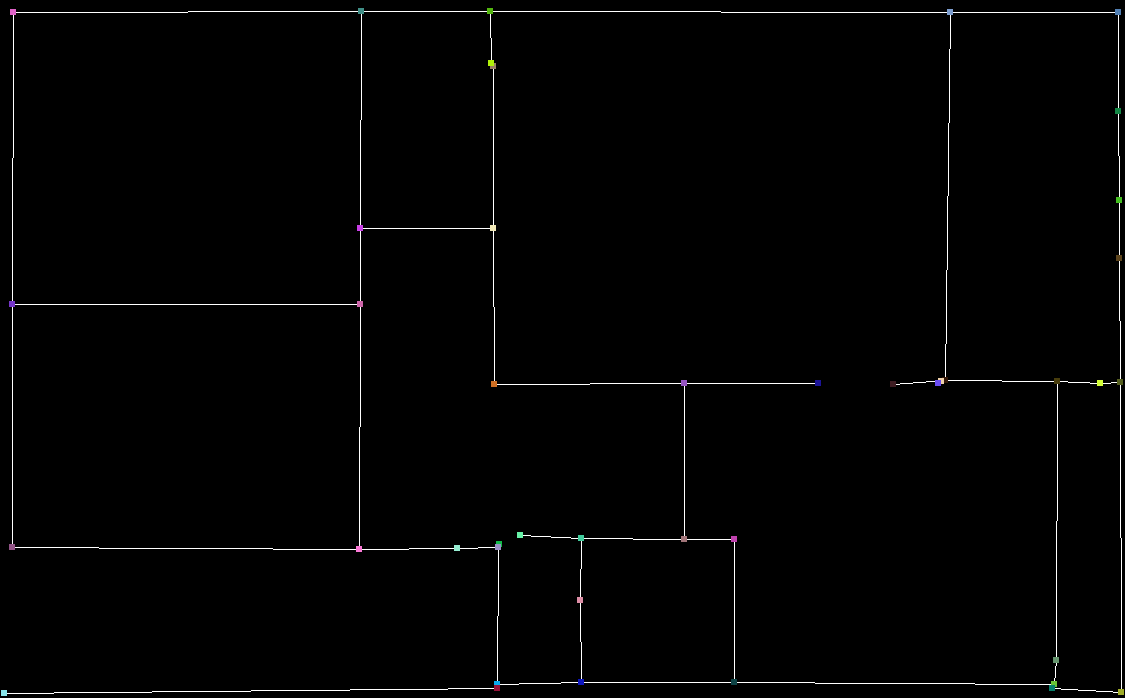

In [12]:
a = np.zeros((*skel.shape, 3))
for [u,v] in connections:
    a = cv2.line(a, coords[u,::-1].astype(np.int32), coords[v,::-1].astype(np.int32), [1,1,1], 1)

L = 3
for [y,x] in coords:
    a[y - L: y + L, x - L: x + L] = np.random.rand(1, 3)
show(a)

In [13]:
print(len(coords))

43


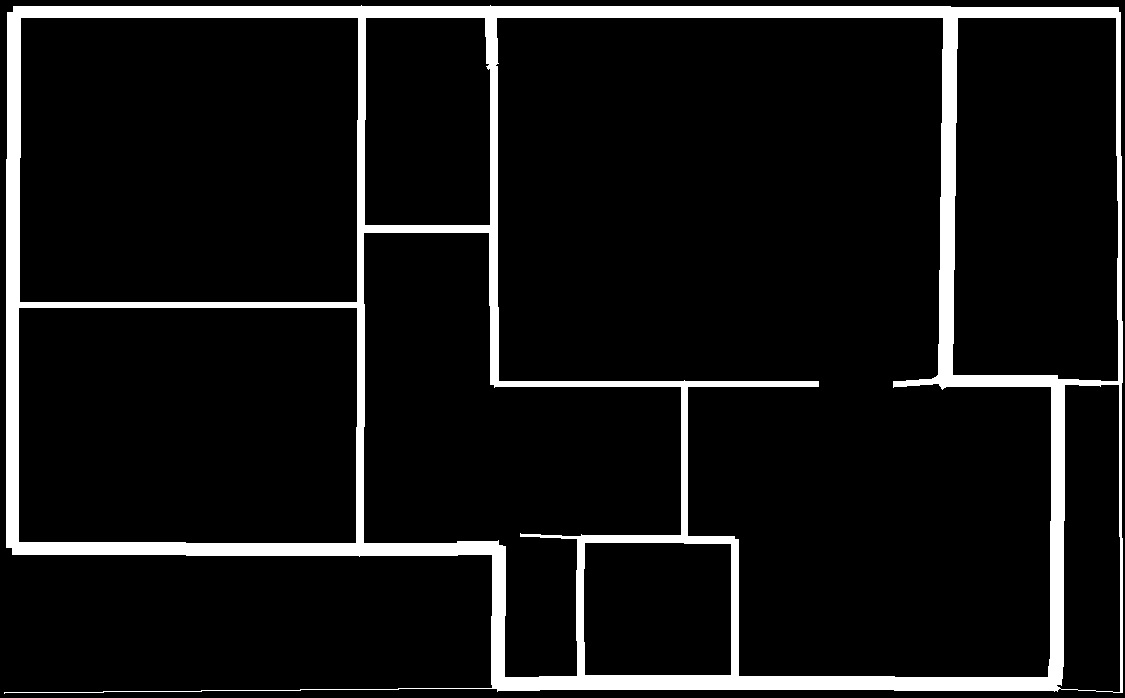

In [14]:
# width deduction

def _width_search(c, p, mask):
    # last_r = 0
    # r = 1
    shape = mask.shape

    # c1 = c - p.astype(np.int32)
    # c2 = c + p.astype(np.int32)
    # while mask[c1[0], c1[1]] and mask[c2[0], c2[1]]:
    #     last_r = r
    #     r = 2 * r

    #     c1 = c - (r * p).astype(np.int32)
    #     c2 = c + (r * p).astype(np.int32)

    #     cond = []
    #     for i in [0, 1]:
    #         if c[i] - c1[i] > 0:
    #             cond += [
    #                 abs(c[i] / (c[i] - c1[i])),
    #                 abs((shape[i] - 1 - c[i]) / (c1[i] - c[i]))
    #             ]
    #         if c[i] - c2[i] > 0:
    #             cond += [
    #                 abs(c[i] / (c[i] - c2[i])),
    #                 abs((shape[i] - 1 - c[i]) / (c2[i] - c[i]))
    #             ]
    #     d = min(cond)
    #     if d < 1:
    #         r = r * d
    #         break

    # while (r - last_r) > 0.5:
    #     cn = (last_r + r) / 2
        
    #     c1 = c - (cn * p).astype(np.int32)
    #     c2 = c + (cn * p).astype(np.int32)

    #     if mask[c1[0], c1[1]] and mask[c2[0], c2[1]]:
    #         last_r = cn
    #     else:
    #         r = cn
    is_valid = lambda pt: pt[0] >= 0 and pt[0] < shape[0] and pt[1] >= 0 and pt[1] < shape[1]

    r = 0
    c1, c2 = c, c
    while mask[c1[0], c1[1]] and mask[c2[0], c2[1]]:
        r += 1
        c1 = c - (r * p).astype(np.int32)
        c2 = c + (r * p).astype(np.int32)

        if not (is_valid(c1) and is_valid(c2)):
            return r
    return r


def optimize_width(c1, c2, mask, sample=100):
    point_vector = c2 - c1
    dist = np.linalg.norm(point_vector)
    normalized_vector = point_vector / dist
    perpendicular_vector = normalized_vector[::-1] * np.array([1, -1])

    sample = min(sample, round(dist) + 1)
    coords = [(c1 + (c2 - c1) * (i / sample)).round().astype(np.int32) for i in range(sample)]

    widths = np.array([_width_search(c, perpendicular_vector, mask) for c in coords])
    return np.median(widths) 


from PIL import ImageDraw
a = Image.new("RGB", (skel.shape[1], skel.shape[0]))
dr = ImageDraw.Draw(a)
segment_width = []
for [u,v] in connections:
    width = optimize_width(coords[u], coords[v], conv)
    segment_width.append(width)
    color = tuple((np.random.rand(3) * 255).astype(np.int32))
    dr.line([tuple(coords[u,::-1]), tuple(coords[v,::-1])], fill=(255,255,255), width=round(width))
display(a)

In [15]:
grad16 = np.around([[
    np.sin(i * np.pi / 8),
    np.cos(i * np.pi / 8),
] for i in range(24)], decimals=5)

threshold = 0.7
change = connections.shape[0]
while change > (1 - threshold) * connections.shape[0]:
    change = 0
    for [u,v] in connections:
        cu = coords[u]
        cv = coords[v]

        dist = np.linalg.norm(cu - cv)
        norm_vector = (cu - cv) / dist
        preferred_grad_index = np.argmin(np.abs(grad16 - norm_vector).sum(axis=1))
        preferred_grad = grad16[preferred_grad_index]

        fixed = (cu + cv) / 2
        dv = fixed - dist * preferred_grad / 2
        du = fixed + dist * preferred_grad / 2

        dv = dv.round().astype(np.int32)
        du = du.round().astype(np.int32)

        if not ((du == cu).all() and (dv == cv).all()):
            change += 1
            coords[u] = du
            coords[v] = dv

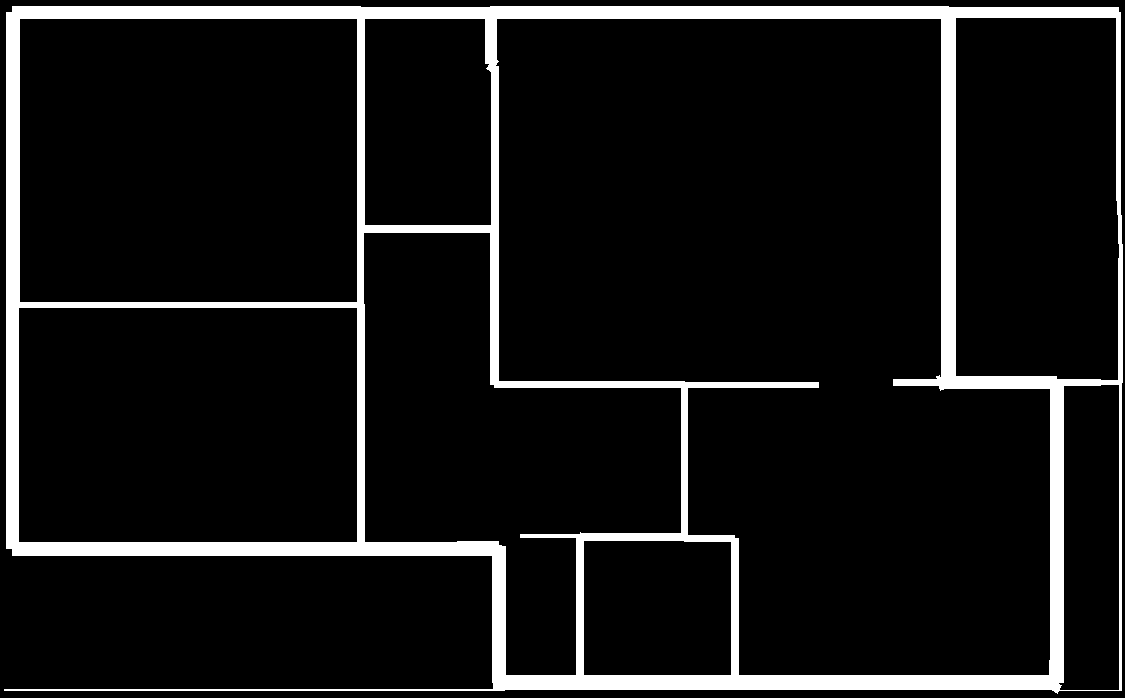

In [16]:
from PIL import ImageDraw
a = Image.new("RGB", (skel.shape[1], skel.shape[0]))
dr = ImageDraw.Draw(a)
# segment_width = []
for idx,[u,v] in enumerate(connections):
    width = segment_width[idx]
    color = tuple((np.random.rand(3) * 255).astype(np.int32))
    dr.line([tuple(coords[u,::-1]), tuple(coords[v,::-1])], fill=(255,255,255), width=round(width))
display(a)

In [17]:
from enum import Enum

import numpy as np

from skimage.filters import butterworth
from skimage.morphology import skeletonize
from skimage.feature import corner_subpix

from rdp import rdp


Connectivity = Enum('Connectivity', 'FOUR EIGHT')


class WallPostProcessing():
    def __init__(self, logger):
        self.logger = logger

        self.original_mask = None
        self.size = None
        self.mask = None
        self.skel = None

        self.coords = None
        self.coord_edges = None
        self.coord_degree = None

        self.coord_partitions = None


    def __call__(self, mask, **kwargs):
        self.original_mask = mask
        self.size = np.array(mask.shape)

        self._mask_skeleton(mask.copy(), **kwargs)
        self._find_skeleton_edges(**kwargs)
        
        pass


    def _is_valid_point(self, point):
        return (point >= np.zeros(2)).all() and (point < self.size).all()


    def _mask_skeleton(
        self,
        mask,
        _mask_skeleton_cutoff_frequency_ratio=0.16,
        _mask_skeleton_order=8.0,
        _mask_skeleton_confidence_value=0.3,
        **kwargs
    ):
        mask[[0, -1],:] = 0
        mask[:,[0, -1]] = 0

        mask = (mask + mask.min()) / (mask.max() + mask.min())

        kwargs = {
            'cutoff_frequency_ratio': _mask_skeleton_cutoff_frequency_ratio,
            'order': _mask_skeleton_order,
            'high_pass': False
        }
        self.mask = butterworth(mask, **kwargs) >= _mask_skeleton_confidence_value
        self.skel = skeletonize(self.mask)


    def _find_skeleton_edges(
        self,
        _skeleton_edge_connectivity_type=Connectivity.EIGHT,
        **kwargs
    ):
        assert (_skeleton_edge_connectivity_type in [Connectivity.FOUR, Connectivity.EIGHT])

        coords = np.argwhere(self.skel)
        coords_idx = np.zeros_like(self.skel) - 1
        coords_LEN = len(coords)

        for idx,[x,y] in enumerate(coords):
            coords_idx[x,y] = idx

        if _skeleton_edge_connectivity_type == Connectivity.EIGHT:
            connectivity = np.array([
                [0, 0, 1, 1, 1, -1, -1, -1],
                [1, -1, 0, 1, -1, 0, 1, -1]
            ]).T
        else:
            connectivity = np.array([
                [0, 0, 1, -1],
                [1, -1, 0, 0]
            ]).T

        coord_edges = []
        coord_degree = np.zeros((coords_LEN), dtype=np.int8)

        for _ in range(coords_LEN):
            coord_edges.append([])

        for idx,point in enumerate(coords):
            for connection in connectivity:
                next_point = point + connection

                if not self._is_valid_point(next_point):
                    continue

                next_target = coords_idx[next_point[0], next_point[1]]

                if next_target > -1:
                    coord_edges[idx].append(next_target)
                    coord_degree[idx] += 1
        
        self.coords = coords
        self.coord_edges = coord_edges
        self.coord_degree = coord_degree


    def _graph_partitioning(
        self,
        **kwargs
    ):
        coords_LEN = len(self.coords)

        static_points = np.where(self.coord_degree > 2)[0]
        if static_points.shape[0] == 0:
            static_points = np.random.choice(np.where(self.coord_degree > 1)[0], 1)

        # belum dilanjut
        visited = np.zeros((coords_LEN), dtype=np.bool_)
        self.coord_partitions = []

        for point in static_points:
            if visited[point]:
                continue

            queue = []
            queue.append(point)
            while len(queue) > 0:
                current = queue.pop(0)
                visited[current] = True

                for next_coord in self.coord_edges[current]:
                    if visited[next_coord]:
                        continue

                    # create new partition
                    partition = [current]
                    part_current = current
                    part_next = connection

                    while True:
                        part_current = part_next
                        partition.append(part_current)
                        if self.coord_degree[part_current] != 2 or part_current == current:
                            break

                        visited[part_current] = True
                        for conn in self.coord_edges[part_current]:
                            if visited[conn]:
                                continue
                            part_next = conn


                    self.coord_partitions.append(partition)
                    if self.coord_degree[part_current] > 2:
                        queue.append(part_current)


    def _polygon_simplification(
        self,
        _rdp_epsilon=1.0,
        _corner_subpix_window_size=48,
        _nms_radius=3,
        _nms_threshold=0.5,
        **kwargs
    ):
        coords_LEN = len(self.coords)
        connections = []
        used_coords = []
        for partition in self.coord_partitions:
            partition = np.array(partition)
            partition_mask = rdp(skel_arguments[partition], epsilon=_rdp_epsilon, return_mask=True)
            new_partition = partition[partition_mask]
            used_coords_partition = []
            for coord in new_partition:
                used_coords_partition.append(coord)
            for idx in range(1, len(new_partition)):
                connections.append([new_partition[idx - 1], new_partition[idx]])
            used_coords += used_coords_partition

        inverse_used_coords = np.zeros((coords_LEN), dtype=np.int32) - 1
        for i,coord in enumerate(used_coords):
            inverse_used_coords[coord] = i
        for i,[u,v] in enumerate(connections):
            connections[i] = [
                inverse_used_coords[u],
                inverse_used_coords[v]
            ]

        before_subpix_coords = self.coords[used_coords]
        coords = corner_subpix(skel, before_subpix_coords, window_size=_corner_subpix_window_size).round()
        for idx,[x,y] in enumerate(coords):
            if math.isnan(x):
                coords[idx] = before_subpix_coords[idx]
        coords = coords.astype(np.int32)

        coords, mask_coords = self._non_max_suppression(coords, _nms_radius, _nms_threshold)

        connections = np.unique(
            np.array([
                [mask_coords[u], mask_coords[v]] for [u,v] in new_connections
            ])
        , axis=0)

        delete_connection = np.where(connections[:,0] == connections[:,1])
        connections = np.delete(connections, delete_connection, axis=0)

        self.coord_edges = connections
        self.coords = coords


    def _non_max_suppression(boxes, radius, overlapThresh):
        if len(boxes) == 0:
            return []
        double_rad_ = 2 * radius + 1
        boxes = boxes.astype(np.float32)
        pick = []
        
        area = double_rad_ * double_rad_
        idxs = np.argsort(y2)
        mapper = np.empty(boxes.shape[0], dtype=np.int32)
        
        while len(idxs) > 0:
            last = len(idxs) - 1
            i = idxs[last]
            new_id = len(pick)
            pick.append(i)

            x1 = np.maximum(boxes[i,0], boxes[idxs[:last],0])
            y1 = np.maximum(boxes[i,1], boxes[idxs[:last],1])
            x2 = np.minimum(boxes[i,0], boxes[idxs[:last],0])
            y2 = np.minimum(boxes[i,1], boxes[idxs[:last],1])

            w = np.clip(x2 - x1 + double_rad_, a_min=0, a_max=None)
            h = np.clip(y2 - y1 + double_rad_, a_min=0, a_max=None)

            overlap = (w * h) / area

            must_delete = np.concatenate(([last], np.where(overlap > overlapThresh)[0]))
            mapper[idxs[must_delete]] = new_id
            idxs = np.delete(idxs, must_delete)
            
        return boxes[pick].round().astype(np.int32), mapper
    
    
    def _width_abduction(
        self,
        **kwargs
    ):
        for idx,[u,v] in enumerate(self.coord_edges):
            point_vector = self.coords[u] - self.coords[v]
            dist = np.linalg.norm(point_vector)
            normalized_vector = point_vector / dist
            perpendicular_vector = normalized_vector[::-1] * np.array([1, -1])

            sample = min(sample, round(dist) + 1)
            coords = [(self.coords[u] + point_vector * (i / sample)).round().astype(np.int32) for i in range(sample)]

            sample_width = np.array([_width_search(c, perpendicular_vector) for c in coords])

            self.coord_edges[idx].append(np.median(sample_width))


    def _width_search_naive(self, c, p):
        r = 0
        c1, c2 = c, c
        while self.mask[c1[0], c1[1]] and self.mask[c2[0], c2[1]]:
            r += 1
            c1 = c - (r * p).astype(np.int32)
            c2 = c + (r * p).astype(np.int32)

            if not (self._is_valid_point(c1) and self._is_valid_point(c2)):
                return r
        return r